In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt


In [3]:
league_data = pd.read_csv('./preprocessed_2023_LoL_esports_match_data_from_OraclesElixir.csv')
league_data.head()

,patch,side,position,playername,champion,gamelength,result,kills,deaths,assists,...,inhibitors,opp_inhibitors,dpm,damagetakenperminute,damagemitigatedperminute,wpm,wcpm,vspm,earned gpm,cspm
0,13.01,0,0,0,0,2612,1,4,0,6,...,1.0,0.0,328.0934,719.5406,878.9127,0.4594,0.1149,1.1256,304.3874,9.1654
1,13.01,0,1,1,1,2612,1,2,2,4,...,0.0,0.0,142.8560,847.3047,1513.9663,0.4135,0.2527,1.4012,148.8055,3.6524
2,13.01,0,2,2,2,2612,1,2,2,11,...,0.0,0.0,620.8576,365.3522,323.7289,0.5283,0.2297,1.1256,232.4196,7.7412
3,13.01,0,3,3,3,2612,1,5,1,7,...,1.0,0.0,964.8928,398.4533,234.3721,0.3905,0.1378,1.0796,269.4028,8.4992
4,13.01,0,4,4,4,2612,1,0,2,10,...,0.0,0.0,130.1991,360.2757,284.1501,1.1945,0.1838,2.4349,73.7825,0.4824


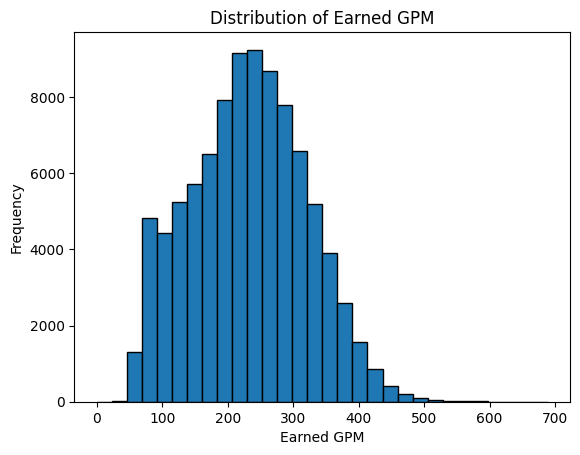

In [4]:
plt.hist(league_data['earned gpm'], bins=30, edgecolor='black')
plt.xlabel('Earned GPM')
plt.ylabel('Frequency')
plt.title('Distribution of Earned GPM')
plt.show()


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


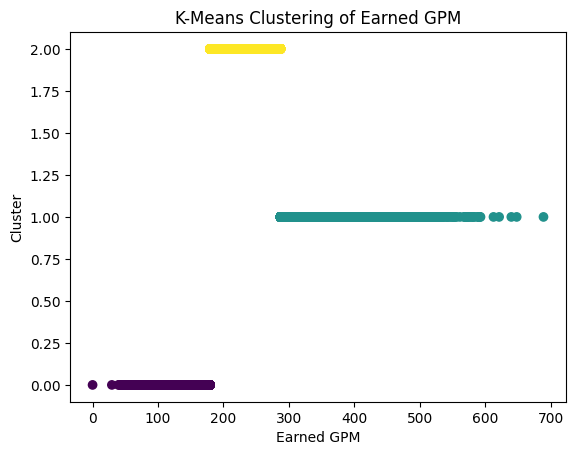

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)
league_data['gpm_range'] = kmeans.fit_predict(league_data[['earned gpm']])
plt.scatter(league_data['earned gpm'], league_data['gpm_range'], c=league_data['gpm_range'], cmap='viridis')
plt.xlabel('Earned GPM')
plt.ylabel('Cluster')
plt.title('K-Means Clustering of Earned GPM')
plt.show()


In [8]:
centers = np.sort(kmeans.cluster_centers_.flatten())

boundaries = [(centers[i] + centers[i+1])/2 for i in range(len(centers)-1)]

def gpm_range(gpm):
    if gpm < boundaries[0]:
        return 'low'
    elif boundaries[0] <= gpm < boundaries[1]:
        return 'medium'
    else:
        return 'high'

league_data['gpm_range'] = league_data['earned gpm'].apply(gpm_range)

print(f"Boundary between low and medium: {boundaries[0]:.2f}")
print(f"Boundary between medium and high: {boundaries[1]:.2f}")

<generator object <genexpr> at 0x0000017DAC9FA490>
Boundary between low and medium: 179.30
Boundary between medium and high: 287.11


In [46]:
features = ['champion', 'kills', 'deaths', 'assists', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim']
target = 'earned gpm'

def gpm_range(gpm):
    if gpm < 179.3:
        return 'low'
    elif 179.3 <= gpm < 287.1:
        return 'medium'
    else:
        return 'high'

league_data['gpm_range'] = league_data['earned gpm'].apply(gpm_range)
league_data.head()

,patch,side,position,playername,champion,gamelength,result,kills,deaths,assists,...,opp_inhibitors,dpm,damagetakenperminute,damagemitigatedperminute,wpm,wcpm,vspm,earned gpm,cspm,gpm_range
0,13.01,0,0,0,0,2612,1,4,0,6,...,0.0,328.0934,719.5406,878.9127,0.4594,0.1149,1.1256,304.3874,9.1654,high
1,13.01,0,1,1,1,2612,1,2,2,4,...,0.0,142.8560,847.3047,1513.9663,0.4135,0.2527,1.4012,148.8055,3.6524,low
2,13.01,0,2,2,2,2612,1,2,2,11,...,0.0,620.8576,365.3522,323.7289,0.5283,0.2297,1.1256,232.4196,7.7412,medium
3,13.01,0,3,3,3,2612,1,5,1,7,...,0.0,964.8928,398.4533,234.3721,0.3905,0.1378,1.0796,269.4028,8.4992,medium
4,13.01,0,4,4,4,2612,1,0,2,10,...,0.0,130.1991,360.2757,284.1501,1.1945,0.1838,2.4349,73.7825,0.4824,low


In [47]:
#remove all rows where "position" is NOT 4
league_data = league_data[league_data['position'] != 4]

sample_set = league_data.sample(frac=0.1, random_state=42)
league_data = league_data[~league_data.index.isin(sample_set.index)]


In [48]:
X = league_data[['champion', 'kills', 'deaths', 'assists', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim']]
y_reg = league_data['earned gpm']
y_clf = league_data['gpm_range']

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(X, y_reg, y_clf, test_size=0.2, random_state=42)

In [49]:
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),  # Applying dimensionality reduction
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [50]:
reg_pipeline.fit(X_train, y_reg_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=4)),
                ('regressor', RandomForestRegressor(random_state=42))])

In [51]:
y_reg_pred = reg_pipeline.predict(X_test)
reg_mape = np.mean(np.abs((y_reg_test - y_reg_pred) / y_reg_test)) * 100
print(f'Regression Mean Absolute Percentage Error: {reg_mape}%')

Regression Mean Absolute Percentage Error: 13.428071492017878%


In [52]:
clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

In [53]:
clf_pipeline.fit(X_train, y_clf_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [54]:
y_clf_pred = clf_pipeline.predict(X_test)
clf_accuracy = accuracy_score(y_clf_test, y_clf_pred)
print(f'Classification Accuracy: {clf_accuracy}')
print('Classification Report:')
print(classification_report(y_clf_test, y_clf_pred))

Classification Accuracy: 0.738394402227071
Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.71      0.75      3758
         low       0.75      0.56      0.64      2793
      medium       0.71      0.83      0.76      6740

    accuracy                           0.74     13291
   macro avg       0.75      0.70      0.72     13291
weighted avg       0.74      0.74      0.74     13291



In [55]:
sample_row = sample_set.sample(n=1)
# print(sample_row)
sample_test = sample_row[features]
sample_answer = sample_row[features + ['earned gpm', 'gpm_range']]
print(sample_test)
print(sample_answer)

      champion  kills  deaths  assists  firstbloodkill  firstbloodassist  \
4115        83      1       1        9             0.0               0.0   

      firstbloodvictim  
4115               0.0  
      champion  kills  deaths  assists  firstbloodkill  firstbloodassist  \
4115        83      1       1        9             0.0               0.0   

      firstbloodvictim  earned gpm gpm_range  
4115               0.0    286.1782    medium  


In [56]:
sample_pred_reg = reg_pipeline.predict(sample_test)
sample_pred_clf = clf_pipeline.predict(sample_test)
print(f'Sample Prediction (Regression): {sample_pred_reg}')
print(f'Sample Prediction (Classification): {sample_pred_clf}')

print(f'Actual Value: {sample_row["earned gpm"].values[0]}')
print(f'Classification: {sample_row["gpm_range"].values[0]}')


Sample Prediction (Regression): [305.45459111]
Sample Prediction (Classification): ['medium']
Actual Value: 286.1782
Classification: medium
